In [1]:
using SciBmad, CairoMakie, BenchmarkTools

In [2]:
include("../lattices/esr-v6.3.1.jl");

In [4]:
@time twiss(ring);

  0.368180 seconds (5.55 M allocations: 306.743 MiB, 10.26% gc time, 29.85% compilation time: 92% of which was recompilation)


In [45]:
# set RF for 0.05 synch tune
# use FiniteDiff for 2 reasons:
# 1. twiss is compatible only with GTPSA and finite differences
# 2. Need to modify SciBmad.newton for handing it the value and jacobian


using FiniteDiff
import DifferentiationInterface as DI

cavities = ring.line[findall(x->x.kind=="RFCavity", ring.line)]

function setrf!(out_v, in_v, params)
    lat = params[1]
    cavities = params[2]
    for cav in cavities
        cav.voltage=in_v[1]
    end
    out_v[1] = twiss(lat).phi_3[end]+0.05
end

in_v = [4e6]
out_v = [0.0]
res = SciBmad.newton!(setrf!, out_v, in_v, (ring,cavities); backend=DI.AutoFiniteDiff())

(u = [3.35560679069565e6], converged = true, n_iters = 5)

In [47]:
foreach(x->x.voltage=res.u[1], cavities)

In [48]:
t = twiss(ring);
t.phi_3[end]

-0.04999999999999671

In [49]:
# Turn on radiation damping
foreach(x->x.tracking_method=Yoshida(order=2, radiation_damping_on=true), ring.line)

In [50]:
t = twiss(ring)

Table with 28 columns and 6271 rows:
      s        phi_1     beta_1    alpha_1     phi_2     beta_2     ⋯
    ┌────────────────────────────────────────────────────────────────
 1  │ 0.0      0.0       0.590629  -0.0582229  0.0       0.0556272  ⋯
 2  │ 0.0      0.0       0.590629  -0.0582229  0.0       0.0556272  ⋯
 3  │ 5.3      0.223257  48.9552   -9.06396    0.24495   505.784    ⋯
 4  │ 7.1      0.226984  153.858   -63.0251    0.245476  454.983    ⋯
 5  │ 7.6      0.227413  223.335   -75.9308    0.245676  346.282    ⋯
 6  │ 9.0      0.228166  337.243   7.17389     0.246552  216.132    ⋯
 7  │ 16.75    0.232547  235.355   5.9677      0.253576  142.881    ⋯
 8  │ 22.2501  0.236869  174.459   5.11367     0.260889  100.464    ⋯
 9  │ 42.0647  0.279022  32.8696   2.02825     0.351286  13.5219    ⋯
 10 │ 42.3147  0.280252  31.8648   1.98934     0.354278  13.0874    ⋯
 11 │ 42.4647  0.281008  31.2712   1.96599     0.356121  12.8346    ⋯
 12 │ 43.0647  0.284153  29.7673   0.572379    0.3639

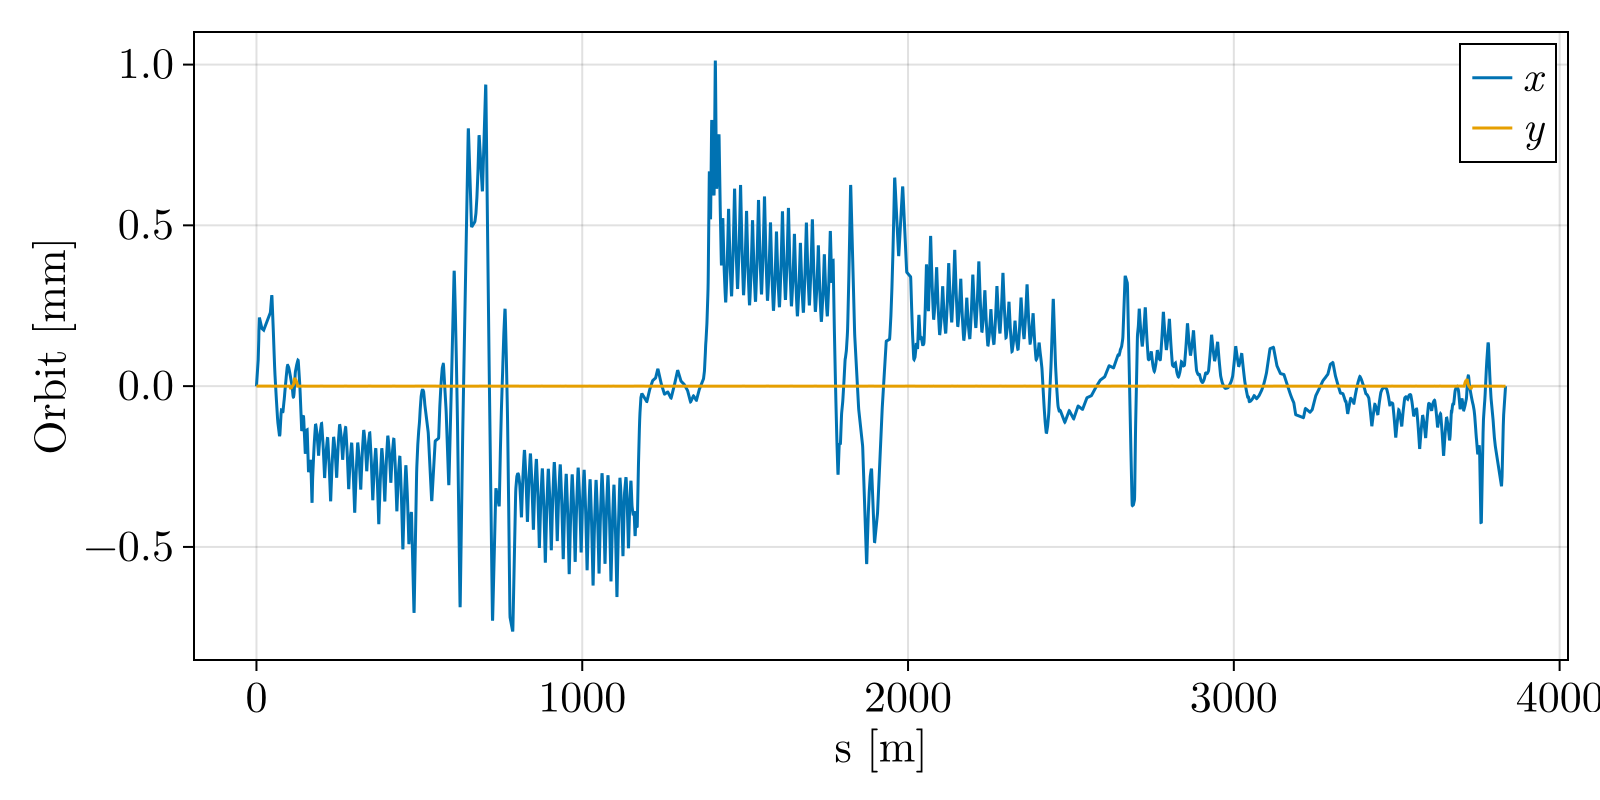

In [54]:
# Plot the orbit:
set_theme!(theme_latexfonts())

f = Figure(fontsize=22, size=(800,400));
ax = Axis(f[1, 1], xlabel="s [m]", ylabel="Orbit [mm]");
lines!(ax, t.s, t.orbit_x.*10^3, label=L"x"); 
lines!(ax, t.s, t.orbit_y.*10^3, label=L"y");
axislegend(position=:rt);
display(f);